In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from pyearth import Earth

# Data Cleaning

In [145]:
train = pd.read_csv('train_subset.csv')

In [146]:
test = pd.read_csv('test_subset.csv')

In [147]:
y = pd.read_csv('train_labels.csv')

In [148]:
# merge response + predictors
train = pd.merge(train, y)
test = pd.merge(test, y)

In [149]:
train_filtered = train.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [150]:
test_filtered = test.drop(['Unnamed: 0','customer_ID','S_2','D_63','D_64'],axis=1)

In [151]:
# storing missing values for each column in train
val_train = train_filtered.isna().sum()

# storing missing values for each column in test
val_test = test_filtered.isna().sum()

In [152]:
# creating dataframe to store how many values are missing in each column for both train and test
na_df = pd.DataFrame(columns = train_filtered.columns)
test_na_df = pd.DataFrame(columns = test_filtered.columns)
test_na_df.loc['Train'] = val_train
test_na_df.loc['Test'] = val_test
na_df.loc['Train'] = val_train
na_df.loc['Test'] = val_test

In [155]:
# identify predictors with large number of missing values 
col_missing = []
for col in na_df.columns:
    if na_df.loc['Train',col]/10000 > .8:
        col_missing.append(col)

In [156]:
# identify predictors with large number of missing values 
test_col_missing = []
for col in test_na_df.columns:
    if test_na_df.loc['Train',col]/10000 > .8:
        test_col_missing.append(col)

In [157]:
# drop predictors with more than 80% missing values
train_filtered = train_filtered.drop(col_missing,axis=1)

In [160]:
test_filtered = test_filtered.drop(test_col_missing,axis=1)

In [162]:
imputer = KNNImputer(n_neighbors=1)

In [163]:
train_filtered = pd.DataFrame(imputer.fit_transform(train_filtered),columns = train_filtered.columns)

In [164]:
test_filtered = pd.DataFrame(imputer.fit_transform(test_filtered),columns = test_filtered.columns)

In [167]:
train_filtered.to_csv('train_clean.csv')

In [168]:
test_filtered.to_csv('test_clean.csv')

In [196]:
test_filtered

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target
0,0.910519,0.003323,0.002007,0.813010,0.000483,0.164135,0.008578,0.005668,0.015702,0.002834,...,0.001487,0.008845,0.003424,0.005055,0.003387,0.006381,0.009071,0.000452,0.009093,0.0
1,0.916596,0.002949,0.007152,0.810892,0.007676,0.164135,0.004424,0.007180,0.015702,0.002115,...,0.000661,0.001575,0.004340,0.009045,0.005062,0.008398,0.009962,0.009318,0.003389,0.0
2,0.913374,0.000478,0.002182,0.815958,0.000189,0.164135,0.003844,0.006892,0.015702,0.005679,...,0.007952,0.001629,0.006936,0.002448,0.006637,0.002498,0.002704,0.009881,0.006629,0.0
3,0.907133,0.009843,0.009453,0.819477,0.008656,0.164135,0.001826,0.000576,0.015702,0.004294,...,0.005089,0.000058,0.000533,0.008992,0.002036,0.000650,0.007807,0.007089,0.009498,0.0
4,0.871219,0.009839,0.000488,0.814127,0.003975,0.164135,0.002952,0.001971,0.015702,0.003254,...,0.007130,0.005932,0.004834,0.000094,0.006466,0.006941,0.000021,0.009241,0.008565,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.923459,0.038349,0.034290,1.007538,0.003336,0.074092,0.000943,0.009005,0.035222,0.002907,...,0.008891,0.000086,0.000409,0.007934,0.005344,0.006785,0.002709,0.005027,0.008763,0.0
9996,0.968773,0.682007,0.033532,1.004179,0.005582,0.068700,0.001663,0.002438,0.034049,0.007320,...,0.004538,0.005462,0.001390,0.000122,0.002820,0.002444,0.006658,0.003938,0.005537,0.0
9997,0.994103,0.237832,0.028541,1.008582,0.002640,0.055308,0.004520,0.005361,0.031825,0.009472,...,0.000662,0.003891,0.004251,0.001989,0.006962,0.000827,0.003828,0.008829,0.000494,0.0
9998,0.971680,0.802516,0.037812,1.007390,0.006115,0.026462,0.007735,0.003908,0.031825,0.001587,...,0.004761,0.006838,0.009980,0.004796,0.005723,0.002804,0.004543,0.004120,0.000063,0.0


# Bagging Decision Trees

In [2]:
train_filtered = pd.read_csv('train_clean.csv')

In [3]:
test_filtered = pd.read_csv('test_clean.csv')

In [4]:
# Separating the predictors and response
y_train = train_filtered.target
X_train = train_filtered.drop('target',axis =1)
y_test = test_filtered.target
X_test = test_filtered.drop('target',axis=1)

In [5]:
#Bagging the results of 10 decision trees
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=1,
                        n_jobs=-1).fit(X_train, y_train)

# Coarse Grid Search

In [20]:
params = {'max_samples': [0.3,0.5,0.7],
          'max_features': [0.3,0.5,0.7],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(estimator = DecisionTreeClassifier(random_state = 1),
                                                         n_estimators=250, random_state=1, n_jobs=-1, bootstrap=True),
                                       param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                       scoring = ['accuracy', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Train accuracy : 1.000
Test accuracy : 0.867
Best accuracy Through Grid Search : 0.877
Best Parameters :  {'bootstrap_features': True, 'max_features': 0.7, 'max_samples': 0.7}


In [21]:
#Bagging the results of 10 decision trees
opt_bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                          n_estimators=250,
                          random_state=1,
                          max_features=0.7,
                          max_samples=0.7,
                          n_jobs=-1,
                          bootstrap=True,
                          bootstrap_features=True,
                                 oob_score=True).fit(X_train, y_train)

In [22]:
ypred = opt_bag_model.predict_proba(X_train)[:,1]

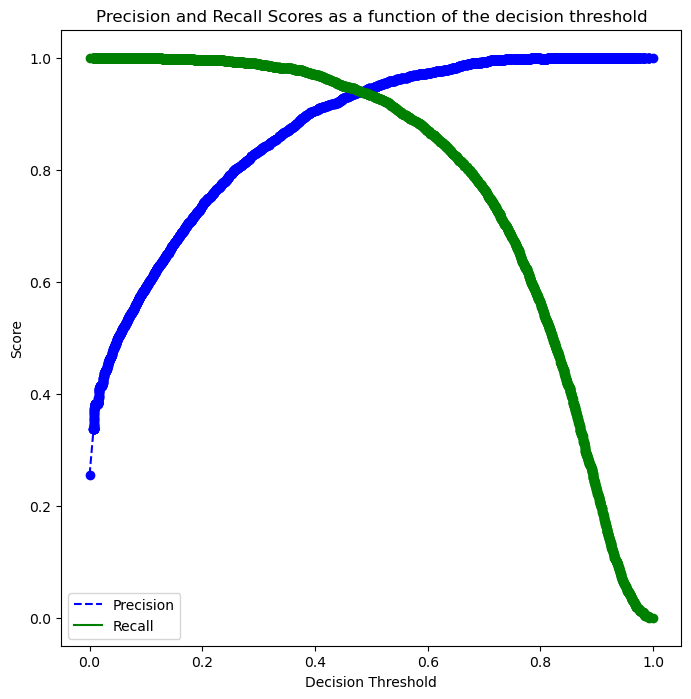

In [23]:
ypred = opt_bag_model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  86.83
ROC-AUC:  0.9268810712422668
Precision:  0.7685804860866502
Recall:  0.7677691766361717


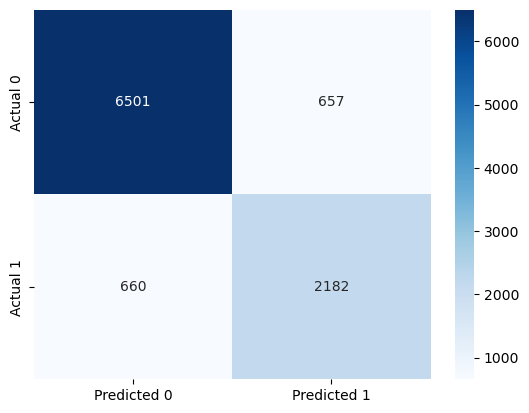

In [37]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.45

y_pred_prob = opt_bag_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Fine Grid Search

In [28]:
params = {'max_samples': [0.6,0.7,0.8],
          'max_features': [0.6,0.7,0.8],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=2,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(estimator = DecisionTreeClassifier(random_state = 1),
                                                         n_estimators=250, random_state=1, n_jobs=-1, bootstrap=True),
                                       param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                       scoring = ['accuracy', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
Train accuracy : 1.000
Test accuracy : 0.865
Best accuracy Through Grid Search : 0.887
Best Parameters :  {'bootstrap_features': False, 'max_features': 0.6, 'max_samples': 0.8}


In [29]:
#Bagging the results of 10 decision trees
finer_bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(random_state=1),
                          n_estimators=250,
                          random_state=1,
                          max_features=0.6,
                          max_samples=0.8,
                          n_jobs=-1,
                          bootstrap=True,
                          bootstrap_features=True,
                                 oob_score=True).fit(X_train, y_train)

In [32]:
ypred = finer_bag_model.predict_proba(X_train)[:,1]

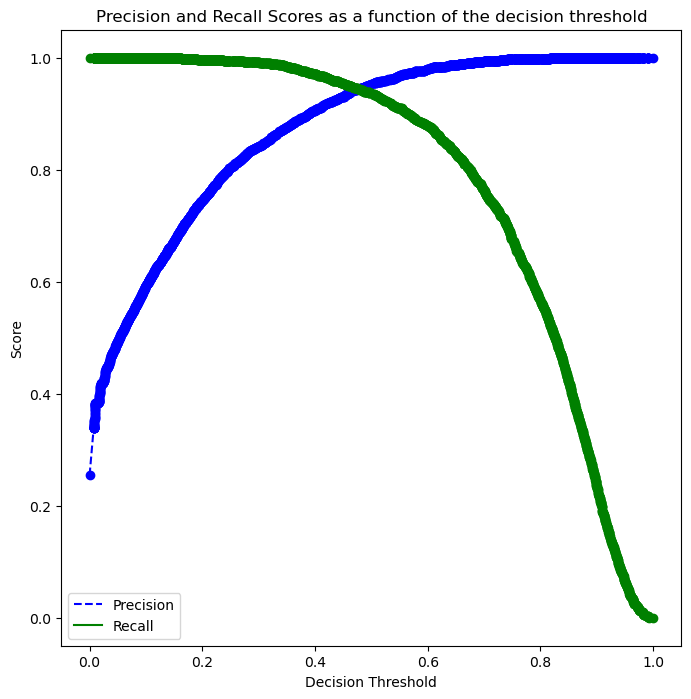

In [33]:
ypred = finer_bag_model.oob_decision_function_[:,1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

Accuracy:  86.65
ROC-AUC:  0.9276927003422695
Precision:  0.7674831380901669
Recall:  0.7607318789584799


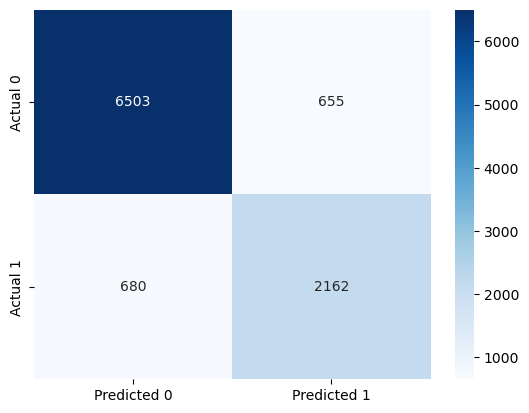

In [36]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.45

y_pred_prob = finer_bag_model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');